In [64]:
import warnings
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score, mean_squared_error
warnings.filterwarnings('ignore')
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np
import random

In [65]:
data = pd.read_csv('finalized_county.csv')

In [66]:
tarrant = data[data['county'] == 'Tarrant'].loc[:, ['date', 'incremental_cases']]
tarrant['incremental_cases'] = tarrant['incremental_cases'].astype('int')
tarrant['date'] = pd.to_datetime(tarrant['date'], format="%Y-%m-%d")

# use 85%-15% for train-test split
train = tarrant.iloc[:230, :]
test = tarrant.iloc[230:, :]

def stationary_test(series):
    result = adfuller(series)
    return (result[0], result[1])


In [67]:
# Tarrant is non-stationary
print("Stationary or not?:", stationary_test(train.incremental_cases))

# get this value for reversion purposes
print(train.loc[train['date'] == '2020-10-25', 'incremental_cases'])

# first-level differencing
train['incremental_cases'] = train['incremental_cases'].diff(
).fillna(train['incremental_cases']).astype('int')

# Tarrant is stationary after first-level differencing
print("Stationary after first level diff?:", stationary_test(train.incremental_cases))

Stationary or not?: (-0.7851430797441187, 0.8234472689051321)
3199    642
Name: incremental_cases, dtype: int64
Stationary after first level diff?: (-7.253082067142602, 1.7592508012141803e-10)


<AxesSubplot:xlabel='date', ylabel='incremental_cases'>

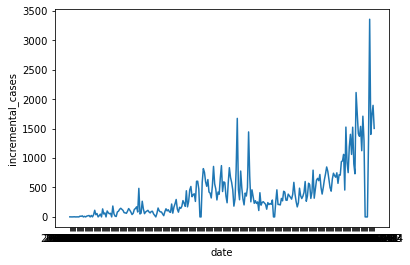

In [68]:
# use non-differenced cases for test actuals
testing = data[data['county'] == 'Tarrant'].loc[:, ['date', 'incremental_cases']]
test = testing.iloc[230:, :]

# Plotting actual test data
sns.lineplot(x="date", y="incremental_cases",legend = 'full' , data=testing)

In [13]:
train = train.loc[:, ['incremental_cases']].reset_index().drop(columns='index')
n_splits = 3

tscv = TimeSeriesSplit(n_splits=n_splits)

p_values = [0, 1, 2, 3]
d_values = [1]
q_values = [0, 1, 2, 3]
P_values = [0, 1, 2, 3]
D_values = [1]
Q_values = [0, 1, 2, 3]
m_values = [30]  

# Generate all possible combinations of parameters
all_combinations = [(p, d, q, P, D, Q, m) for p in p_values for d in d_values for q in q_values
                    for P in P_values for D in D_values for Q in Q_values for m in m_values]

# Randomize
random.shuffle(all_combinations)

# Limit the number of iterations
max_iterations = 20  
limited_combinations = all_combinations[:max_iterations]

best_score, best_cfg = float("inf"), None

# Iterate through the randomized/limited combinations of parameters
for (p, d, q, P, D, Q, m) in limited_combinations:
    mse_scores = []

    for train_index, val_index in tscv.split(train):
        try:
            train_data, val_data = train.loc[train_index], train.loc[val_index]
            model = SARIMAX(train_data.incremental_cases,
                            order=(p, d, q),
                            seasonal_order=(P, D, Q, m),
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            model_fit = model.fit(disp=0)
            forecast = model_fit.forecast(steps=len(val_data))
            mse = mean_squared_error(val_data.incremental_cases, forecast)
            mse_scores.append(mse)
        except:
            mse_scores.append(float("inf"))  # In case the model fitting fails

    average_mse = np.mean(mse_scores)
    if average_mse < best_score:
        best_score, best_cfg = average_mse, ((p, d, q), (P, D, Q, m))

print(f'Best SARIMA parameters: {best_cfg} with MSE: {best_score}')

Best SARIMA parameters: ((2, 1, 3), (0, 1, 1, 30)) with MSE: 64182.1413255427


In [69]:
model = sm.tsa.statespace.SARIMAX(train.incremental_cases, order=(2, 1, 3), seasonal_order=(0,1,1,30)).fit()
pred = pd.concat([pd.Series([642]), model.forecast(steps=40)]).cumsum()[1:]
r2 = r2_score(test.incremental_cases, pred)
print("R-squared", r2) 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.11184D+00    |proj g|=  2.61184D-01


 This problem is unconstrained.



At iterate    5    f=  5.98581D+00    |proj g|=  4.81891D-02

At iterate   10    f=  5.96041D+00    |proj g|=  1.82842D-02

At iterate   15    f=  5.94844D+00    |proj g|=  2.89695D-01

At iterate   20    f=  5.93702D+00    |proj g|=  8.74951D-03

At iterate   25    f=  5.93463D+00    |proj g|=  1.91225D-02

At iterate   30    f=  5.93456D+00    |proj g|=  2.48345D-02

At iterate   35    f=  5.93370D+00    |proj g|=  2.99136D-02

At iterate   40    f=  5.93361D+00    |proj g|=  6.28337D-03

At iterate   45    f=  5.93345D+00    |proj g|=  1.59389D-02

At iterate   50    f=  5.93092D+00    |proj g|=  4.99643D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

<AxesSubplot:xlabel='date'>

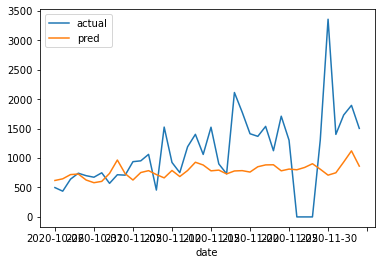

In [70]:
prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True), 
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [16]:
train = train.loc[:, ['incremental_cases']].reset_index().drop(columns='index')
n_splits = 3

tscv = TimeSeriesSplit(n_splits=n_splits)

# Non-seasonal ARIMA parameters
p_values = [2, 3]
d_values = [1]
q_values = [1, 2, 3]

# Seasonal parameters
P_values = [0, 1, 2, 3]  
D_values = [1]  
Q_values = [2, 3]  
m_values = [30]    

best_score, best_cfg = float("inf"), None

# Iterate through all combinations of parameters
for p in p_values:
    for d in d_values:
        for q in q_values:
            for P in P_values:
                for D in D_values:
                    for Q in Q_values:
                        for m in m_values:
                            mse_scores = []  # List to store the MSE of each cross-validation fold
                            
                            # Cross-validation as the inner loop
                            for train_index, val_index in tscv.split(train):
                                try:
                                    train_data, val_data = train.loc[train_index], train.loc[val_index]
                                    model = SARIMAX(train_data.incremental_cases,
                                                    order=(p, d, q),
                                                    seasonal_order=(P, D, Q, m),
                                                    enforce_stationarity=False,
                                                    enforce_invertibility=False)
                                    model_fit = model.fit(disp=0)
                                    forecast = model_fit.forecast(steps=len(val_data))
                                    mse = mean_squared_error(val_data.incremental_cases, forecast)
                                    mse_scores.append(mse)
                                except:
                                    mse_scores.append(float("inf"))  
                            
                            average_mse = np.mean(mse_scores)  # Average MSE over all folds
                            if average_mse < best_score:
                                best_score, best_cfg = average_mse, ((p, d, q), (P, D, Q, m))

print(f'Best SARIMA parameters: {best_cfg} with MSE: {best_score}')

Best SARIMA parameters: ((2, 1, 2), (0, 1, 2, 30)) with MSE: 66557.50419641519


In [71]:
model = sm.tsa.statespace.SARIMAX(train.incremental_cases, order=(2, 1, 2), seasonal_order=(0,1,2,30)).fit()
pred = pd.concat([pd.Series([642]), model.forecast(steps=40)]).cumsum()[1:]
r2 = r2_score(test.incremental_cases, pred)
print("R-squared", r2) 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.08200D+00    |proj g|=  3.15310D-01

At iterate    5    f=  5.97668D+00    |proj g|=  7.88775D-03

At iterate   10    f=  5.95453D+00    |proj g|=  3.15702D-02

At iterate   15    f=  5.92743D+00    |proj g|=  7.05316D-03

At iterate   20    f=  5.92673D+00    |proj g|=  3.94498D-03

At iterate   25    f=  5.92243D+00    |proj g|=  7.62130D-03

At iterate   30    f=  5.82131D+00    |proj g|=  1.34895D-01

At iterate   35    f=  5.77004D+00    |proj g|=  4.16750D-03

At iterate   40    f=  5.77001D+00    |proj g|=  1.41225D-03

At iterate   45    f=  5.76982D+00    |proj g|=  5.49286D-04

At iterate   50    f=  5.76977D+00    |proj g|=  1.87574D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

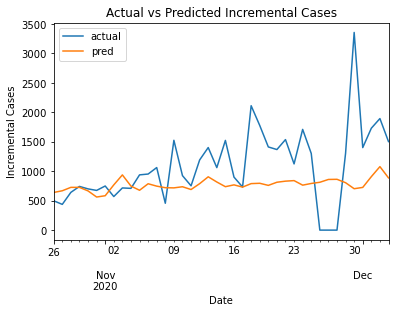

In [72]:
test['date'] = pd.to_datetime(test['date'], format="%Y-%m-%d")

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True), 
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
ax = prediction.plot(x = 'date', y = ['actual', 'pred'])

# Set the labels for the x and y axes
ax.set_xlabel('Date')
ax.set_ylabel('Incremental Cases')

# Optionally, you can also set the title of the plot
ax.set_title('Actual vs Predicted Incremental Cases')

# Show the plot
plt.show()

In [73]:
harris = data[data['county'] == 'Harris'].loc[:, ['date', 'incremental_cases']]
harris['incremental_cases'] = harris['incremental_cases'].astype('int')
harris['date'] = pd.to_datetime(harris['date'], format="%Y-%m-%d")

# use 85%-15% for train-test split
train = harris.iloc[:230, :]
test = harris.iloc[230:, :]

def stationary_test(series):
    result = adfuller(series)
    return (result[0], result[1])


In [74]:
# Harris is non-stationary
print("Stationary or not?:", stationary_test(train.incremental_cases))

# get this value for reversion purposes
print(train.loc[train['date'] == '2020-10-25', 'incremental_cases'])

# first-level differencing
train['incremental_cases'] = train['incremental_cases'].diff(
).fillna(train['incremental_cases']).astype('int')

# Harris is stationary after first-level differencing
print("Stationary after first level diff?:", stationary_test(train.incremental_cases))

Stationary or not?: (-2.2416106051506035, 0.19149116285834866)
2929    379
Name: incremental_cases, dtype: int64
Stationary after first level diff?: (-8.652159828218712, 5.0809546880530815e-14)


<AxesSubplot:xlabel='date', ylabel='incremental_cases'>

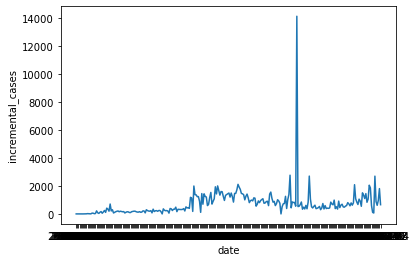

In [75]:
# use non-differenced cases for test actuals
testing = data[data['county'] == 'Harris'].loc[:, ['date', 'incremental_cases']]
test = testing.iloc[230:, :]

# Plotting actual test data
sns.lineplot(x="date", y="incremental_cases",legend = 'full' , data=testing)

In [22]:
train = train.loc[:, ['incremental_cases']].reset_index().drop(columns='index')
n_splits = 3

tscv = TimeSeriesSplit(n_splits=n_splits)

p_values = [0, 1, 2, 3]
d_values = [1]
q_values = [0, 1, 2, 3]
P_values = [0, 1, 2, 3]
D_values = [1]
Q_values = [0, 1, 2, 3]
m_values = [30]  

# Generate all possible combinations of parameters
all_combinations = [(p, d, q, P, D, Q, m) for p in p_values for d in d_values for q in q_values
                    for P in P_values for D in D_values for Q in Q_values for m in m_values]

# Randomize
random.shuffle(all_combinations)

# Limit the number of iterations
max_iterations = 20  
limited_combinations = all_combinations[:max_iterations]

best_score, best_cfg = float("inf"), None

# Iterate through the randomized/limited combinations of parameters
for (p, d, q, P, D, Q, m) in limited_combinations:
    mse_scores = []

    for train_index, val_index in tscv.split(train):
        try:
            train_data, val_data = train.loc[train_index], train.loc[val_index]
            model = SARIMAX(train_data.incremental_cases,
                            order=(p, d, q),
                            seasonal_order=(P, D, Q, m),
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            model_fit = model.fit(disp=0)
            forecast = model_fit.forecast(steps=len(val_data))
            mse = mean_squared_error(val_data.incremental_cases, forecast)
            mse_scores.append(mse)
        except:
            mse_scores.append(float("inf"))  # In case the model fitting fails

    average_mse = np.mean(mse_scores)
    if average_mse < best_score:
        best_score, best_cfg = average_mse, ((p, d, q), (P, D, Q, m))

print(f'Best SARIMA parameters: {best_cfg} with MSE: {best_score}')

Best SARIMA parameters: ((3, 1, 1), (1, 1, 0, 30)) with MSE: 2362459.4580989517


In [76]:
model = sm.tsa.statespace.SARIMAX(train.incremental_cases, order=(3, 1, 1), seasonal_order=(1,1,0,30)).fit()
pred = pd.concat([pd.Series([379]), model.forecast(steps=40)]).cumsum()[1:]
r2 = r2_score(test.incremental_cases, pred)
print("R-squared", r2) 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.57967D+00    |proj g|=  7.31971D-02

At iterate    5    f=  7.55181D+00    |proj g|=  1.74787D-02

At iterate   10    f=  7.53538D+00    |proj g|=  2.46219D-02

At iterate   15    f=  7.53390D+00    |proj g|=  6.59103D-04

At iterate   20    f=  7.53357D+00    |proj g|=  5.51777D-04

At iterate   25    f=  7.53350D+00    |proj g|=  2.80860D-03

At iterate   30    f=  7.41094D+00    |proj g|=  6.59695D-02

At iterate   35    f=  7.38791D+00    |proj g|=  1.50550D-03

At iterate   40    f=  7.38582D+00    |proj g|=  2.45406D-03

At iterate   45    f=  7.34890D+00    |proj g|=  1.22045D-02

At iterate   50    f=  7.34877D+00    |proj g|=  1.44936D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

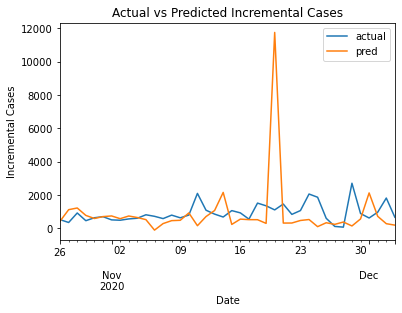

In [77]:
test['date'] = pd.to_datetime(test['date'], format="%Y-%m-%d")

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True), 
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
ax = prediction.plot(x = 'date', y = ['actual', 'pred'])

# Set the labels for the x and y axes
ax.set_xlabel('Date')
ax.set_ylabel('Incremental Cases')

# Optionally, you can also set the title of the plot
ax.set_title('Actual vs Predicted Incremental Cases')

# Show the plot
plt.show()

In [23]:
train = train.loc[:, ['incremental_cases']].reset_index().drop(columns='index')
n_splits = 3

tscv = TimeSeriesSplit(n_splits=n_splits)

# Non-seasonal ARIMA parameters
p_values = [2, 3]
d_values = [1]
q_values = [1, 2, 3]

# Seasonal parameters
P_values = [0, 1, 2, 3]  
D_values = [1]  
Q_values = [2, 3]  
m_values = [30]    

best_score, best_cfg = float("inf"), None

# Iterate through all combinations of parameters
for p in p_values:
    for d in d_values:
        for q in q_values:
            for P in P_values:
                for D in D_values:
                    for Q in Q_values:
                        for m in m_values:
                            mse_scores = []  # List to store the MSE of each cross-validation fold
                            
                            # Cross-validation as the inner loop
                            for train_index, val_index in tscv.split(train):
                                try:
                                    train_data, val_data = train.loc[train_index], train.loc[val_index]
                                    model = SARIMAX(train_data.incremental_cases,
                                                    order=(p, d, q),
                                                    seasonal_order=(P, D, Q, m),
                                                    enforce_stationarity=False,
                                                    enforce_invertibility=False)
                                    model_fit = model.fit(disp=0)
                                    forecast = model_fit.forecast(steps=len(val_data))
                                    mse = mean_squared_error(val_data.incremental_cases, forecast)
                                    mse_scores.append(mse)
                                except:
                                    mse_scores.append(float("inf"))  
                            
                            average_mse = np.mean(mse_scores)  # Average MSE over all folds
                            if average_mse < best_score:
                                best_score, best_cfg = average_mse, ((p, d, q), (P, D, Q, m))

print(f'Best SARIMA parameters: {best_cfg} with MSE: {best_score}')

Best SARIMA parameters: ((3, 1, 1), (2, 1, 2, 30)) with MSE: 2365086.718210355


In [78]:
model = sm.tsa.statespace.SARIMAX(train.incremental_cases, order=(3, 1, 1), seasonal_order=(2,1,2,30)).fit()
pred = pd.concat([pd.Series([379]), model.forecast(steps=40)]).cumsum()[1:]
r2 = r2_score(test.incremental_cases, pred)
print("R-squared", r2) 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.56924D+00    |proj g|=  8.35743D-02

At iterate    5    f=  7.53589D+00    |proj g|=  1.70089D-02

At iterate   10    f=  7.52997D+00    |proj g|=  5.27002D-03

At iterate   15    f=  7.52978D+00    |proj g|=  2.88489D-04

At iterate   20    f=  7.52960D+00    |proj g|=  6.29861D-03

At iterate   25    f=  7.52699D+00    |proj g|=  2.12102D-02

At iterate   30    f=  7.50666D+00    |proj g|=  8.27944D-03
  ys=-7.961E-02  -gs= 8.746E-02 BFGS update SKIPPED

At iterate   35    f=  7.41866D+00    |proj g|=  1.89413D-02

At iterate   40    f=  7.41470D+00    |proj g|=  5.69228D-03

At iterate   45    f=  7.40226D+00    |proj g|=  3.54829D-02

At iterate   50    f=  7.37617D+00    |proj g|=  3.77862D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations


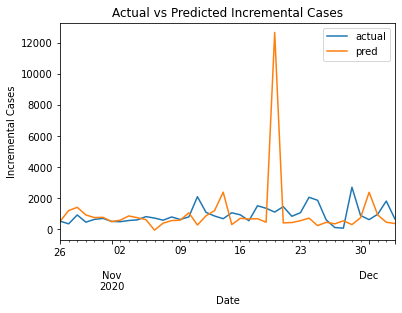

In [79]:
test['date'] = pd.to_datetime(test['date'], format="%Y-%m-%d")

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True), 
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
ax = prediction.plot(x = 'date', y = ['actual', 'pred'])

# Set the labels for the x and y axes
ax.set_xlabel('Date')
ax.set_ylabel('Incremental Cases')

# Optionally, you can also set the title of the plot
ax.set_title('Actual vs Predicted Incremental Cases')

# Show the plot
plt.show()

In [80]:
philly = data[data['county'] == 'Philadelphia'].loc[:, ['date', 'incremental_cases']]
philly['incremental_cases'] = philly['incremental_cases'].astype('int')
philly['date'] = pd.to_datetime(philly['date'], format="%Y-%m-%d")

# use 85%-15% for train-test split
train = philly.iloc[:230, :]
test = philly.iloc[230:, :]

def stationary_test(series):
    result = adfuller(series)
    return (result[0], result[1])


In [81]:
# Philly is non-stationary
print("Stationary or not?:", stationary_test(train.incremental_cases))

# get this value for reversion purposes
print(train.loc[train['date'] == '2020-10-25', 'incremental_cases'])

# first-level differencing
train['incremental_cases'] = train['incremental_cases'].diff(
).fillna(train['incremental_cases']).astype('int')

# Philly is stationary after first-level differencing
print("Stationary after first level diff?:", stationary_test(train.incremental_cases))

Stationary or not?: (-2.587596964172684, 0.09558791429258168)
2659    0
Name: incremental_cases, dtype: int64
Stationary after first level diff?: (-3.2081320654001626, 0.01951876252889616)


<AxesSubplot:xlabel='date', ylabel='incremental_cases'>

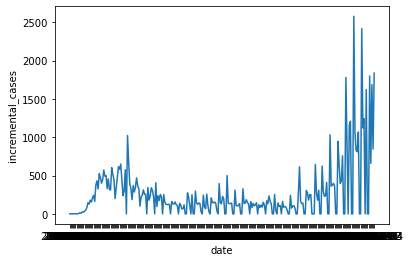

In [82]:
# use non-differenced cases for test actuals
testing = data[data['county'] == 'Philadelphia'].loc[:, ['date', 'incremental_cases']]
test = testing.iloc[230:, :]

# Plotting actual test data
sns.lineplot(x="date", y="incremental_cases",legend = 'full' , data=testing)

In [27]:
train = train.loc[:, ['incremental_cases']].reset_index().drop(columns='index')
n_splits = 3

tscv = TimeSeriesSplit(n_splits=n_splits)

p_values = [0, 1, 2, 3]
d_values = [1]
q_values = [0, 1, 2, 3]
P_values = [0, 1, 2, 3]
D_values = [1]
Q_values = [0, 1, 2, 3]
m_values = [30]  

# Generate all possible combinations of parameters
all_combinations = [(p, d, q, P, D, Q, m) for p in p_values for d in d_values for q in q_values
                    for P in P_values for D in D_values for Q in Q_values for m in m_values]

# Randomize
random.shuffle(all_combinations)

# Limit the number of iterations
max_iterations = 20  
limited_combinations = all_combinations[:max_iterations]

best_score, best_cfg = float("inf"), None

# Iterate through the randomized/limited combinations of parameters
for (p, d, q, P, D, Q, m) in limited_combinations:
    mse_scores = []

    for train_index, val_index in tscv.split(train):
        try:
            train_data, val_data = train.loc[train_index], train.loc[val_index]
            model = SARIMAX(train_data.incremental_cases,
                            order=(p, d, q),
                            seasonal_order=(P, D, Q, m),
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            model_fit = model.fit(disp=0)
            forecast = model_fit.forecast(steps=len(val_data))
            mse = mean_squared_error(val_data.incremental_cases, forecast)
            mse_scores.append(mse)
        except:
            mse_scores.append(float("inf"))  # In case the model fitting fails

    average_mse = np.mean(mse_scores)
    if average_mse < best_score:
        best_score, best_cfg = average_mse, ((p, d, q), (P, D, Q, m))

print(f'Best SARIMA parameters: {best_cfg} with MSE: {best_score}')

Best SARIMA parameters: ((2, 1, 3), (1, 1, 1, 30)) with MSE: 53272.020348650905


In [83]:
model = sm.tsa.statespace.SARIMAX(train.incremental_cases, order=(2, 1, 3), seasonal_order=(1,1,1,30)).fit()
pred = pd.concat([pd.Series([0]), model.forecast(steps=40)]).cumsum()[1:]
r2 = r2_score(test.incremental_cases, pred)
print("R-squared", r2) 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.45800D+00    |proj g|=  1.31791D+00

At iterate    5    f=  5.82196D+00    |proj g|=  1.29343D-01

At iterate   10    f=  5.74973D+00    |proj g|=  5.65823D-02

At iterate   15    f=  5.74316D+00    |proj g|=  1.69456D-02

At iterate   20    f=  5.73927D+00    |proj g|=  3.76519D-02

At iterate   25    f=  5.73809D+00    |proj g|=  7.53130D-03

At iterate   30    f=  5.73796D+00    |proj g|=  2.25036D-03

At iterate   35    f=  5.73756D+00    |proj g|=  8.34065D-03

At iterate   40    f=  5.73077D+00    |proj g|=  2.99409D-01

At iterate   45    f=  5.70763D+00    |proj g|=  6.85705D-02

At iterate   50    f=  5.70357D+00    |proj g|=  9.64110D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

<AxesSubplot:xlabel='date'>

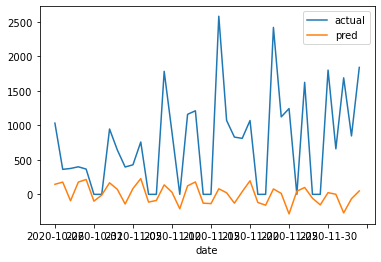

In [84]:
prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True), 
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [28]:
train = train.loc[:, ['incremental_cases']].reset_index().drop(columns='index')
n_splits = 3

tscv = TimeSeriesSplit(n_splits=n_splits)

# Non-seasonal ARIMA parameters
p_values = [2, 3]
d_values = [1]
q_values = [1, 2, 3]

# Seasonal parameters
P_values = [0, 1, 2, 3]  
D_values = [1]  
Q_values = [2, 3]  
m_values = [30]    

best_score, best_cfg = float("inf"), None

# Iterate through all combinations of parameters
for p in p_values:
    for d in d_values:
        for q in q_values:
            for P in P_values:
                for D in D_values:
                    for Q in Q_values:
                        for m in m_values:
                            mse_scores = []  # List to store the MSE of each cross-validation fold
                            
                            # Cross-validation as the inner loop
                            for train_index, val_index in tscv.split(train):
                                try:
                                    train_data, val_data = train.loc[train_index], train.loc[val_index]
                                    model = SARIMAX(train_data.incremental_cases,
                                                    order=(p, d, q),
                                                    seasonal_order=(P, D, Q, m),
                                                    enforce_stationarity=False,
                                                    enforce_invertibility=False)
                                    model_fit = model.fit(disp=0)
                                    forecast = model_fit.forecast(steps=len(val_data))
                                    mse = mean_squared_error(val_data.incremental_cases, forecast)
                                    mse_scores.append(mse)
                                except:
                                    mse_scores.append(float("inf"))  
                            
                            average_mse = np.mean(mse_scores)  # Average MSE over all folds
                            if average_mse < best_score:
                                best_score, best_cfg = average_mse, ((p, d, q), (P, D, Q, m))

print(f'Best SARIMA parameters: {best_cfg} with MSE: {best_score}')

Best SARIMA parameters: ((3, 1, 3), (1, 1, 2, 30)) with MSE: 52878.35323810712


In [85]:
model = sm.tsa.statespace.SARIMAX(train.incremental_cases, order=(3, 1, 3), seasonal_order=(1,1,2,30)).fit()
pred = pd.concat([pd.Series([0]), model.forecast(steps=40)]).cumsum()[1:]
r2 = r2_score(test.incremental_cases, pred)
print("R-squared", r2) 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.32077D+00    |proj g|=  8.92607D-01


 This problem is unconstrained.



At iterate    5    f=  5.72594D+00    |proj g|=  1.10025D-01

At iterate   10    f=  5.69961D+00    |proj g|=  1.03497D-01

At iterate   15    f=  5.68795D+00    |proj g|=  4.97192D-02

At iterate   20    f=  5.68286D+00    |proj g|=  2.52609D-02

At iterate   25    f=  5.68167D+00    |proj g|=  9.32972D-02

At iterate   30    f=  5.68083D+00    |proj g|=  2.54720D-02

At iterate   35    f=  5.67796D+00    |proj g|=  5.02430D-02

At iterate   40    f=  5.67644D+00    |proj g|=  2.33878D-01

At iterate   45    f=  5.66068D+00    |proj g|=  8.01871D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     48     72   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


R-squared -1.1835632117561223


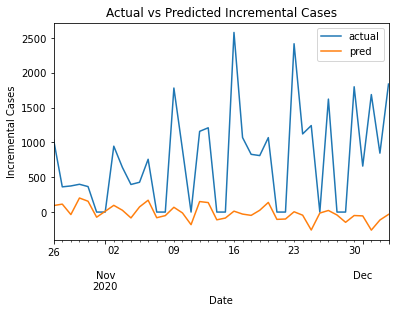

In [86]:
test['date'] = pd.to_datetime(test['date'], format="%Y-%m-%d")

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True), 
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
ax = prediction.plot(x = 'date', y = ['actual', 'pred'])

# Set the labels for the x and y axes
ax.set_xlabel('Date')
ax.set_ylabel('Incremental Cases')

# Optionally, you can also set the title of the plot
ax.set_title('Actual vs Predicted Incremental Cases')

# Show the plot
plt.show()